In [1]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [2]:
# Clear GPU memory cache
torch.cuda.empty_cache()

# Assuming the annotations are in a text file
annotations_file = 'annotation.txt'  # Replace with your actual annotation file path
image_folder = './'  # Replace with your actual image folder path

# Read the annotations
annotations = pd.read_csv(annotations_file, sep=' ', header=None)

In [3]:
# Define the transformations: ToTensor converts image to float32, and Normalize scales the values
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Converts PIL image to torch.FloatTensor and scales pixel values to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Optional normalization
])

In [4]:
# Load images and gaze vectors
images = []
gaze_vectors = []
for idx, row in annotations.iterrows():
    # Format the image filename as '0001.jpg', '0002.jpg', ...
    image_filename = f'{idx + 1:04d}.jpg'
    image_path = os.path.join(image_folder, image_filename)

    # Open the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image = data_transforms(image)

    images.append(image)
    gaze_vectors.append(row[-3:].values)  # Gaze vector (last three values)


In [5]:
# Dataset definition
class GazeDataset(Dataset):
    def __init__(self, images, gaze_vectors):
        self.images = images
        self.gaze_vectors = gaze_vectors

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], torch.tensor(self.gaze_vectors[idx], dtype=torch.float32)

gaze_dataset = GazeDataset(images, gaze_vectors)

In [6]:
# Split into training and validation datasets
train_size = int(0.8 * len(gaze_dataset))
val_size = len(gaze_dataset) - train_size
train_dataset, val_dataset = random_split(gaze_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # Adjust batch size if needed
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [7]:
# CNN model definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Dynamically calculate the input size for fully connected layers
        self.fc1 = None
        self.fc2 = nn.Linear(128, 3)  # Output layer for 3 gaze vector components

        # Initialize the fully connected layer
        self._initialize_fc1()

    def _initialize_fc1(self):
        # Create a dummy tensor with the size of the input images
        dummy_input = torch.randn(1, 3, 224, 224)  # Adjust the size as needed
        # Pass it through the convolutional layers
        x = F.relu(self.conv1(dummy_input))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Calculate the flattened size after the conv layers
        flatten_size = x.numel()  # Get the number of elements
        self.fc1 = nn.Linear(flatten_size, 128)  # Set the input size for fc1

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model, loss function, and optimizer
model = CNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (fc1): Linear(in_features=401408, out_features=128, bias=True)
)

In [13]:

# Training parameters
num_epochs = 100

# # Training and validation loop
# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode
#     running_loss = 0.0

#     # Training loop
#     for images, gaze_vectors in train_loader:
#         # Move data to GPU if available
#         images = images.to(device)
#         gaze_vectors = gaze_vectors.to(device)

#         # Zero gradients from the previous step
#         optimizer.zero_grad()

#         # Forward pass: compute the output
#         outputs = model(images)

#         # Compute the loss
#         loss = criterion(outputs, gaze_vectors)

#         # Backward pass: compute gradients
#         loss.backward()

#         # Update the model parameters
#         optimizer.step()

#         # Accumulate the running loss
#         running_loss += loss.item()

#     # Calculate average loss over the epoch
#     epoch_loss = running_loss / len(train_loader)
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

#     # Validation loop
#     model.eval()  # Set model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # No need to compute gradients during validation
#         for images, gaze_vectors in val_loader:
#             images = images.to(device)
#             gaze_vectors = gaze_vectors.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, gaze_vectors)
#             val_loss += loss.item()

#     # Calculate average validation loss
#     val_loss = val_loss / len(val_loader)
#     print(f'Validation Loss: {val_loss:.4f}')


In [14]:
# Initialize lists to store loss values
train_loss_history = []
val_loss_history = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training loop
    for images, gaze_vectors in train_loader:
        # Move data to GPU if available
        images = images.to(device)
        gaze_vectors = gaze_vectors.to(device)

        # Zero gradients from the previous step
        optimizer.zero_grad()

        # Forward pass: compute the output
        outputs = model(images)
        print(outputs)

        # Compute the loss
        loss = criterion(outputs, gaze_vectors)

        # Backward pass: compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    # Calculate average loss over the epoch and store it
    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to compute gradients during validation
        for images, gaze_vectors in val_loader:
            images = images.to(device)
            gaze_vectors = gaze_vectors.to(device)

            outputs = model(images)
            loss = criterion(outputs, gaze_vectors)
            val_loss += loss.item()

    # Calculate average validation loss and store it
    val_loss = val_loss / len(val_loader)
    val_loss_history.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')


tensor([[ 2.9055e+01,  1.7765e-02,  4.6567e+02],
        [ 8.9556e+01,  1.1101e+01,  4.9909e+02],
        [ 5.3077e+01, -4.1321e-02,  3.6810e+02],
        [ 6.2432e+01,  1.7048e+01,  5.5480e+02]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 80.0040,  20.9797, 512.3001],
        [ 37.5438,  33.7644, 501.8464],
        [ 26.0632,  24.7613, 625.2664],
        [ 24.4756,  21.2697, 447.0580]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 67.3499,  27.4945, 566.3073],
        [ 16.0300,  -3.1875, 434.3589],
        [ 71.2017,  18.6465, 506.1754],
        [ 47.5879,  22.4480, 528.5521]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 41.9192,  -2.0075, 470.4914],
        [  1.2674,  -2.3504, 399.8081],
        [ 34.2658, -13.0703, 445.6844],
        [ 38.9209,  18.6327, 421.5302]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 30.3076,  20.7163, 532.6060],
        [ 21.6259,  26.8235, 603.7529],
        [ 12.1957,   7.4010, 511.6427],


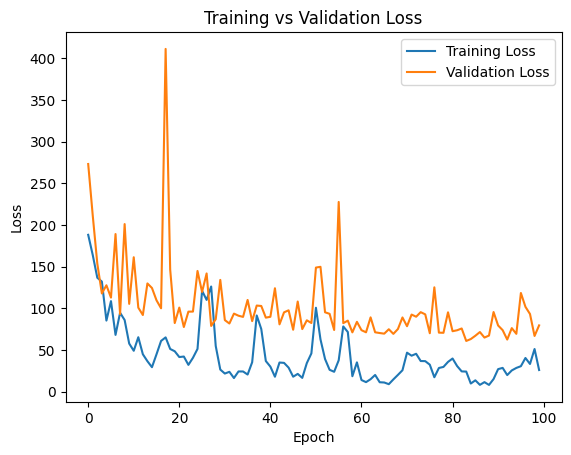

In [15]:
import matplotlib.pyplot as plt

# Assuming `train_loss_history` and `val_loss_history` were recorded during the training loop
plt.plot(range(num_epochs), train_loss_history, label="Training Loss")
plt.plot(range(num_epochs), val_loss_history, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate accuracy metrics
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    mse_losses = []
    mae_losses = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, gaze_vectors in dataloader:
            images = images.to(device)
            gaze_vectors = gaze_vectors.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate individual loss metrics
            mse_loss = mean_squared_error(gaze_vectors.cpu().numpy(), outputs.cpu().numpy())
            mae_loss = mean_absolute_error(gaze_vectors.cpu().numpy(), outputs.cpu().numpy())

            mse_losses.append(mse_loss)
            mae_losses.append(mae_loss)

    # Average losses across the dataset
    avg_mse_loss = np.mean(mse_losses)
    avg_mae_loss = np.mean(mae_losses)

    return avg_mse_loss, avg_mae_loss

# Evaluate the model on the validation set
val_mse, val_mae = evaluate_model(model, val_loader, criterion)

print(f'Validation MSE: {val_mse:.4f}')
print(f'Validation MAE: {val_mae:.4f}')


Validation MSE: 245.9713
Validation MAE: 9.4565


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to bin gaze vectors and calculate confusion matrix
def calculate_confusion_matrix(model, dataloader, bins=5):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, gaze_vectors in dataloader:
            images = images.to(device)
            gaze_vectors = gaze_vectors.to(device)

            # Predict gaze vectors
            outputs = model(images)

            # Bin the true and predicted values
            true_bins = np.digitize(gaze_vectors.cpu().numpy(), bins=np.linspace(-1, 1, bins))
            pred_bins = np.digitize(outputs.cpu().numpy(), bins=np.linspace(-1, 1, bins))

            # Append labels
            true_labels.extend(true_bins.flatten())
            predicted_labels.extend(pred_bins.flatten())

    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(1, bins + 1))
    return cm

# Generate confusion matrix
bins = 5  # Number of bins to discretize gaze vectors
conf_matrix = calculate_confusion_matrix(model, val_loader, bins=bins)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, bins + 1), yticklabels=range(1, bins + 1))
plt.xlabel('Predicted Bins')
plt.ylabel('True Bins')
plt.title('Confusion Matrix for Gaze Prediction')
plt.show()
